# 查看phase1与phase2的区别

## 查看problem数量对不对的上

In [1]:
import json
#分别抽取phase1与phase2的problem，查看重合的有多少
path1 = "/zhuangkai/openo1/dataset/prm800k/data/phase1_{stage}.jsonl"
path2 = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
for stage in ["train", "test"]:
    with open(path1.format(stage=stage), 'r', encoding='utf-8') as f:
        phase1_problems = set()
        for line in f:
            problem = json.loads(line)['question']['problem']
            phase1_problems.add(problem)

    with open(path2.format(stage=stage), 'r', encoding='utf-8') as f:
        phase2_problems = set()
        for line in f:
            problem = json.loads(line)['question']['problem']
            phase2_problems.add(problem)

    print(f"Phase 1 problems in {stage}: {len(phase1_problems)}")
    print(f"Phase 2 problems in {stage}: {len(phase2_problems)}")

    intersect = phase1_problems & phase2_problems
    print(f"Intersect problems in {stage}: {len(intersect)}")



Phase 1 problems in train: 903
Phase 2 problems in train: 10828
Intersect problems in train: 896
Phase 1 problems in test: 101
Phase 2 problems in test: 458
Intersect problems in test: 101


## 查看phase2的ground_truth_answer有多少是数字

In [2]:
import json
from collections import defaultdict
path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
for stage in ["train", "test"]:
    count = 0
    qas = defaultdict(str)
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        phase2_gt_answers = set()
        for line in f:
            problem = json.loads(line)['question']['problem']
            gt_answer = json.loads(line)["question"]['ground_truth_answer']
            qas[problem] = gt_answer

    for problem, gt_answer in qas.items():
        #gt_answer是字符串类型，如果可以被转为数字，则计数+1
        if isinstance(gt_answer, str) and gt_answer.replace('.', '', 1).isdigit():
            count += 1
    print(f"Number of problems with a ground truth answer that is a number in {stage}: {count}")

Number of problems with a ground truth answer that is a number in train: 6575
Number of problems with a ground truth answer that is a number in test: 284


## 查看phase2的ground_truth_answer和pre_generated_answer有多少是相同的


In [7]:
#先严格的比对
import json
from tqdm import tqdm
count = 0
path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
save_path = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_judge_same_strict.jsonl"
for stage in ["train", "test"]:
    count = 0
    results = []
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            timestamp = line["timestamp"]
            problem = line["question"]['problem']
            gt_answer = line["question"]['ground_truth_answer']
            pre_generated_answer = line["question"]['pre_generated_answer']
            pre_generated_steps = line["question"]['pre_generated_steps']
            if gt_answer == pre_generated_answer:
                count += 1
            results_dict = {
                "timestamp": timestamp,
                "problem": problem,
                "is_same": gt_answer == pre_generated_answer,
                "pre_generated_steps": pre_generated_steps
            }
            results.append(results_dict)
    print(f"Number of gt_answer equal to pre_generated_answer in {stage}: {count}")
    with open(save_path.format(stage=stage), 'w', encoding='utf-8') as f:
        for result in tqdm(results):
            f.write(json.dumps(result) + "\n")


97782it [00:03, 30252.82it/s]


Number of gt_answer equal to pre_generated_answer in train: 6002


100%|██████████| 97782/97782 [00:00<00:00, 105866.33it/s]
2762it [00:00, 38972.15it/s]


Number of gt_answer equal to pre_generated_answer in test: 518


100%|██████████| 2762/2762 [00:00<00:00, 123135.04it/s]


In [6]:
#再用大模型判断是否相同
#将项目路径添加到sys.path
import sys
sys.path.append("/zhuangkai/openo1")
from utils.openai_access import call_chatgpt
import json
from tqdm import tqdm
from utils.mpr import MultipleProcessRunnerSimplifier
prompt = """
You are a helpful assistant. You are given a ground truth answer and a pre-generated answer. You need to determine if the pre-generated answer is the same as the ground truth answer.

Ground truth answer: {gt_answer}
Pre-generated answer: {pre_generated_answer}

If they are the same, return "Yes". If they are different, return "No".
For example:
Ground truth answer: (a+b)(c+2)
Pre-generated answer: (c+2)(a+b)
Return: Yes

Ground truth answer: 1
Pre-generated answer: 2
Return: No
"""

def do(process_id, idx, data, writer):
    line = json.loads(data)
    timestamp = line["timestamp"]
    gt_answer = line["question"]['ground_truth_answer']
    pre_generated_answer = line["question"]['pre_generated_answer']
    prompt_instance = prompt.format(gt_answer=gt_answer, pre_generated_answer=pre_generated_answer)
    result = call_chatgpt(prompt_instance)
    result_dict = {
        "timestamp": timestamp,
        "is_same": result == "Yes",
        "gt_answer": gt_answer,
        "pre_generated_answer": pre_generated_answer
    }
    writer.write(json.dumps(result_dict) + "\n")

path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_train.jsonl"
save_path = "/zhuangkai/openo1/outputs/prm800k/phase2_train_judge_same_llm.jsonl"
with open(path, 'r', encoding='utf-8') as f:
    data = f.readlines()

runner = MultipleProcessRunnerSimplifier(
    data=data,
    do=do,
    save_path=save_path,
    n_process=256,  
    verbose=True
)

runner.run()

# 统计yes的数量
count = 0
with open(save_path, 'r') as f:
    for line in f:
        result = json.loads(line.strip())
        if result["is_same"]:
            count += 1
print(f"Number of gt_answer equal to pre_generated_answer: {count}")


[Errno 25] Inappropriate ioctl for device
Can't get terminal size, set terminal_y = None


Input data to queue: 100%|██████████| 97782/97782 [00:00<00:00, 227537.86it/s]


7Total: [#########################################] 100% 97782/97782 [00:21:56 < 00:00:00, 74.29it/s]8

Aggregating results...: 256it [00:00, 1207.83it/s]


Number of gt_answer equal to pre_generated_answer: 8235


# 对phase2的ground_truth_answer与选中的pre_generated_answer进行处理，转成可供训练的数据

## 对gt_answer进行处理，转成step_list(最后采用了首字母大写来划分step)

In [1]:
#用nltk分句
import json
from tqdm import tqdm
import nltk
from collections import defaultdict

nltk.download('punkt', quiet=True)
path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
save_path = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_gt_solution_to_step_list_nltk.jsonl"
def split_solution(solution):
    # 使用NLTK的sent_tokenize函数进行句子分割
    sentences = nltk.sent_tokenize(solution)
    # 过滤空字符串并去除每个步骤的前后空白
    return [s.strip() for s in sentences if s.strip()]
for stage in ["train", "test"]:
    results = defaultdict(list)

    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line['question']['problem']
            gt_answer = line["question"]['ground_truth_answer']
            gt_solution = line["question"]['ground_truth_solution']
            if gt_answer is not None:
                steps = split_solution(gt_solution)
                results[problem]=steps

    with open(save_path.format(stage=stage), 'w', encoding='utf-8') as f:
        for problem, steps in results.items():
            f.write(json.dumps({"problem": problem, "steps": steps}) + "\n")



0it [00:00, ?it/s]


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/root/miniconda3/envs/openo1/nltk_data'
    - '/root/miniconda3/envs/openo1/share/nltk_data'
    - '/root/miniconda3/envs/openo1/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [5]:
#用手写规则分句
import json
from tqdm import tqdm
import nltk
from collections import defaultdict

nltk.download('punkt', quiet=True)
path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
save_path = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_gt_solution_to_step_list.jsonl"
def split_solution(solution):
    split_patterns = [
        r'\.\$ ',                   # ".$ "
        r'\.\\\]',                  # ".\]"
        r'\.\n\n',                  # ".\n\n"
        r'\.\$\n\n',                # ".$\n\n"
        r'\. ',                     # ". "
        r'\. \\end\{aligned\}\\\]', # ". \end{aligned}\]"
        r'\.\n\\end\{align\*\}',    # ".\n\end{align*}"
        r'\.\n\\\]',                # ".\n\]"
        r'\.\n\n',                  # ".\n\n"
        r'\.\n',                    # ".\n"
    ]

    # 合并模式为一个正则表达式
    split_regex = '|'.join(split_patterns)

    # 使用正则表达式分割文本
    sentences = re.split(split_regex, solution)

    # 去除每个句子的首尾空白字符
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences
for stage in ["train", "test"]:
    results = defaultdict(list)

    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line['question']['problem']
            gt_answer = line["question"]['ground_truth_answer']
            gt_solution = line["question"]['ground_truth_solution']
            if gt_answer is not None:
                steps = split_solution(gt_solution)
                results[problem]=steps

    with open(save_path.format(stage=stage), 'w', encoding='utf-8') as f:
        for problem, steps in results.items():
            f.write(json.dumps({"problem": problem, "steps": steps}) + "\n")



97782it [00:03, 29164.79it/s]
2762it [00:00, 5298.27it/s]


In [10]:
#查看分句后的steps每个开头是不是大写
import json
from tqdm import tqdm
count = 0
path = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_gt_solution_to_step_list.jsonl"
# for stage in ["train", "test"]:
for stage in ["test"]:
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            steps = line["steps"]
            for step in steps:
                if not step[0].isupper():
                    print(f"step: {step}")
                    count += 1
print(f"Number of steps that do not start with a capital letter: {count}")


458it [00:00, 50539.10it/s]

step: [asy]
draw((0,0)--(3,0)--(3,3)--(0,3));
draw((0,0)--(0,3));
label("$x$",(3,0),S);
label("$y$",(0,3),W);
fill((1,0)--(3,2)--(3,3)--(2,3)--(0,1)--cycle,gray(.7));
draw((1,-.1)--(1,.1));
draw((2,-.1)--(2,.1));
draw((.1,1)--(-.1,1));
draw((.1,2)--(-.1,2));

draw((1,0)--(0,1));
draw((1,0)--(3,2));
draw((0,1)--(2,3));

[/asy]

The total area of the square is $3^2=9$
step: [asy]
unitsize(1 cm);

real parab (real x) {
  return ((x^2 + 6*x + 13)/4);
}

pair P = (-0.5,parab(-0.5));

draw(graph(parab,-6,0));
draw((-3,2)--P--(-0.5,0));

dot((-3,2));
dot((-3,1));
draw((-6,0)--(0,0),dashed);
[/asy]

By definition of a parabola, for any point $P$ on the parabola, the distance from $P$ to the focus is equal to the distance from $P$ to the $y$-axis, which is the $y$-coordinate of the point
step: \end{aligned}\]Thus, $z_{k+3} = z_k$ for all $k
step: (This technique is often referred to as the Ravi Substitution.)  Note that
\begin{align*}
a &= y + z, \\
b &= x + z, \\
c &= x + y
step: [asy]
draw((0

In [3]:
#用首字母大写来划分step
import json
from tqdm import tqdm
from collections import defaultdict
count = 0
path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
save_path = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_gt_solution_to_step_list_capital.jsonl"
def split_solution(solution):
    steps = []
    current_step = ""
    i = 0
    while i < len(solution):
        if solution[i].isupper() and (i == 0 or solution[i-1] != '('):
            if current_step:
                steps.append(current_step.strip())
            current_step = solution[i]
        elif i > 0 and solution[i].isupper() and solution[i-1] == '(':
            if current_step:
                steps.append(current_step[:-1].strip())
            current_step = '(' + solution[i]
        elif solution[i:i+5] == '[asy]':
            if current_step:
                steps.append(current_step.strip())
            current_step = solution[i:]
            i = len(solution)  # 跳到字符串末尾
        else:
            current_step += solution[i]
        i += 1
    
    if current_step:
        steps.append(current_step.strip())
    
    # 合并包含 [asy] 的步骤与下一个步骤
    merged_steps = []
    i = 0
    while i < len(steps):
        if '[asy]' in steps[i] and i+1 < len(steps):
            merged_steps.append(steps[i] + ' ' + steps[i+1])
            i += 2
        else:
            merged_steps.append(steps[i])
            i += 1
    
    # 合并不含 "." 的步骤
    final_steps = []
    current_step = ""
    for step in merged_steps:
        if step.strip() == "$$" and current_step:
            current_step += " " + step
        else:
            current_step += step + " "
        if "." in current_step:
            final_steps.append(current_step.strip())
            current_step = ""
    
    if current_step:  # 处理最后可能剩余的步骤
        final_steps.append(current_step.strip())
    
    return [step for step in final_steps if step.strip()]

for stage in ["train", "test"]:
    results = defaultdict(list)

    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line['question']['problem']
            gt_answer = line["question"]['ground_truth_answer']
            gt_solution = line["question"]['ground_truth_solution']
            if gt_answer is not None:
                steps = split_solution(gt_solution)
                results[problem]=steps

    with open(save_path.format(stage=stage), 'w', encoding='utf-8') as f:
        for problem, steps in results.items():
            f.write(json.dumps({"problem": problem, "steps": steps}) + "\n")
    




0it [00:00, ?it/s]

97782it [00:20, 4883.03it/s]
2762it [00:01, 2707.85it/s]


In [12]:

#用大模型分句
import sys
sys.path.append("/zhuangkai/openo1")
from utils.openai_access import call_chatgpt
from utils.mpr import MultipleProcessRunnerSimplifier
import json
from tqdm import tqdm
import re
prompt = """
Break down the following mathematical problem solution into a clear list of steps. Each step should be a complete sentence or an independent operational instruction from the original solution. Do not alter the original content; simply divide it into logically independent steps. Ensure to preserve the integrity of all mathematical symbols and formulas.

Example solution input:
To find the factors of 100 and 150, I can use prime factorization and list all the possible combinations of the prime factors. The prime factorization of 100 is 2^2 times 5^2, so the factors of 100 are 1, 2, 4, 5, 10, 20, 25, 50, and 100. The prime factorization of 150 is 2 times 3 times 5^2, so the factors of 150 are 1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75, and 150. To find the common factors of both 100 and 150, I can look for the numbers that appear in both lists. These are 1, 2, 5, 10, 25, and 50. However, the question asks for the positive two-digit integers, so I can eliminate 1, 2, and 5 from the list of common factors. Therefore, the only positive two-digit integers that are factors of both 100 and 150 are 10, 25, and 50, and there are three of them. # Answer\n\n3

Example JSON output:
{
    "steps": ["To find the factors of 100 and 150, I can use prime factorization and list all the possible combinations of the prime factors.", "The prime factorization of 100 is 2^2 times 5^2, so the factors of 100 are 1, 2, 4, 5, 10, 20, 25, 50, and 100.", "The prime factorization of 150 is 2 times 3 times 5^2, so the factors of 150 are 1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75, and 150.", "To find the common factors of both 100 and 150, I can look for the numbers that appear in both lists.", "These are 1, 2, 5, 10, 25, and 50.", "However, the question asks for the positive two-digit integers, so I can eliminate 1, 2, and 5 from the list of common factors.", "Therefore, the only positive two-digit integers that are factors of both 100 and 150 are 10, 25, and 50, and there are three of them.", "# Answer\n\n3"]
}


Note:
1. Do not include the word "step" or any numbering in your response.
2. Each item in the list should directly state the step, using the original wording from the solution.
3. Do not add, remove, or modify any content from the original solution; only divide it into separate steps.
4. If a sentence in the original solution contains multiple key steps, it may be split into multiple steps.
5. Preserve all mathematical notations, equations, and expressions exactly as they appear in the original solution.
"""


def do(process_id, idx, data, writer):
    line = json.loads(data)
    problem = line['question']['problem']
    gt_solution = line['question']['ground_truth_solution']
    if gt_solution:
        prompt_instance = prompt+"\nSolution:\n"+gt_solution
        response = call_chatgpt(prompt_instance)
        steps = response[14:-2]
        result = {"problem": problem, "steps": steps, "response": response}
        writer.write(json.dumps(result) + "\n")

def process_stage(stage):
    path = f"/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
    save_path = f"/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_gt_solution_to_step_list_llm.jsonl"

    with open(path, 'r', encoding='utf-8') as f:
        data = f.readlines()

    runner = MultipleProcessRunnerSimplifier(
        data=data[:test_num],
        do=do,
        save_path=save_path,
        n_process=256,  
        verbose=True
    )

    runner.run()

test_num = 20
# 处理训练集和测试集
for stage in ["test"]:
# for stage in ["train", "test"]:
    process_stage(stage)

print("所有处理完成。")

[Errno 25] Inappropriate ioctl for device
Can't get terminal size, set terminal_y = None


Input data to queue: 100%|██████████| 20/20 [00:00<00:00, 8477.62it/s]


7Total: [##############################################___] 95% 19/20 [00:00:57 < 00:00:03, 3.03s/it]8

Aggregating results...: 256it [00:00, 469.92it/s]

所有处理完成。


## 对pre_generated_answer进行处理，转成step_list

In [5]:
# 将pre_generated_answer转为step_list
import json
from tqdm import tqdm

from collections import defaultdict
read_path1 = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_judge_same_strict.jsonl"
read_path2 = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
save_path = "/zhuangkai/openo1/outputs/prm800k/phase2_{stage}_pre_generated_solution_to_step_list.jsonl"

for stage in ["train", "test"]:
    results = []
    with open(read_path1.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line["problem"]
            pre_generated_steps = line["pre_generated_steps"]
            is_same = line["is_same"]
            if is_same:
                merged_steps = []
                for step in pre_generated_steps:
                    if step == "$$":
                        # 如果当前步骤是"$$"，则与上一个步骤合并
                        if merged_steps:
                            merged_steps[-1] += " " + step  # 合并
                    else:
                        merged_steps.append(step)  # 添加新的步骤
                results.append((problem, merged_steps))

    with open(save_path.format(stage=stage), 'w', encoding='utf-8') as f:
        for problem, steps in results:
            f.write(json.dumps({"problem": problem, "steps": steps}) + "\n")



97782it [00:00, 108869.16it/s]
2762it [00:00, 42532.83it/s]


## 将两个step_list合并，形成一个step_list

In [1]:
# 将两个step_list合并，形成一个step_list
import json
from tqdm import tqdm
from collections import defaultdict
read_path1 = "/zhuangkai/openo1/outputs/sft/phase2_{stage}_gt_solution_to_step_list_capital.jsonl"
read_path2 = "/zhuangkai/openo1/outputs/sft/phase2_{stage}_pre_generated_solution_to_step_list.jsonl"
save_path = "/zhuangkai/openo1/outputs/sft/phase2_{stage}_gt_pre_generated_solution_to_step_list.jsonl"

for stage in ["train", "test"]:
    results = []
    with open(read_path1.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line["problem"]
            gt_steps = line["steps"]
            results.append((problem, gt_steps))

    with open(read_path2.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line["problem"]
            pre_generated_steps = line["steps"]
            results.append((problem, pre_generated_steps))

    with open(save_path.format(stage=stage), 'w', encoding='utf-8') as f:
        for problem, steps in results:
            #如果出现step长度小于10的，则不将该problem写入
            if any(len(step) < 10 for step in steps):
                continue
            f.write(json.dumps({"problem": problem, "steps": steps}) + "\n")
    

0it [00:00, ?it/s]

10819it [00:00, 41983.79it/s]
6002it [00:00, 38901.08it/s]
458it [00:00, 150689.62it/s]
518it [00:00, 117294.69it/s]


## 查看一共有多少steps


In [2]:
#查看一共有多少steps，分stage统计
import json
from tqdm import tqdm
path = "/zhuangkai/openo1/outputs/sft/phase2_{stage}_gt_pre_generated_solution_to_step_list.jsonl"
for stage in ["train", "test"]:
    count = 0
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            steps = line["steps"]
            count += len(steps)
    print(f"Number of steps in {stage}: {count}")

16779it [00:00, 102743.97it/s]


Number of steps in train: 107986


970it [00:00, 121828.86it/s]

Number of steps in test: 7900


## 查看step长度有没有小于指定数字的

In [3]:
#查看step长度有没有小于指定数字的
import json
from tqdm import tqdm
path = "/zhuangkai/openo1/outputs/sft/phase2_{stage}_gt_pre_generated_solution_to_step_list.jsonl"
min_length = 10
for stage in ["train", "test"]:
    count = 0
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            steps = line["steps"]
            for step in steps:
                if len(step) <= min_length:
                    print(f"step: {step}")
                    count += 1
    print(f"Number of steps less than 5 in {stage}: {count}")


16779it [00:00, 93523.23it/s]


step: Wednesday.
step: Math Club.
step: B=\$1.85$.
step: And so on.
step: This gives
step: Which one?
step: So $n=42$.
step: So x = 24.
step: 125 = 5^3.
step: And so on.
step: That's 16.
step: width = 10
step: That is 7.
Number of steps less than 5 in train: 13


970it [00:00, 106135.05it/s]

step: And so on.
step: And so on.
step: And so on.
step: And so on.
Number of steps less than 5 in test: 4


## 查看每个problem的ground_truth_soluton的长度

97782it [00:04, 20530.35it/s]


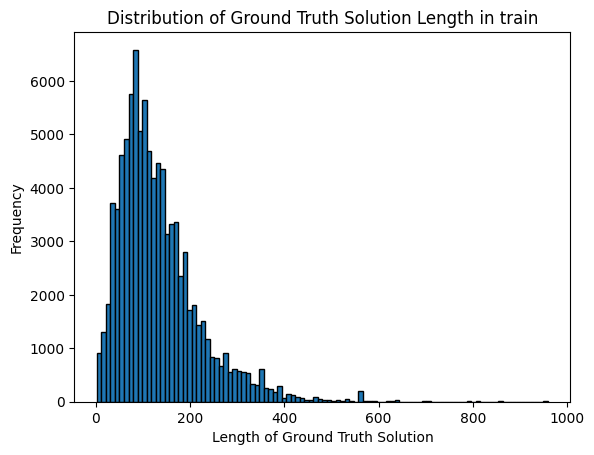

Stage: train
比例大于1024: 0.00%
比例大于2048: 0.00%


2762it [00:00, 5470.39it/s]


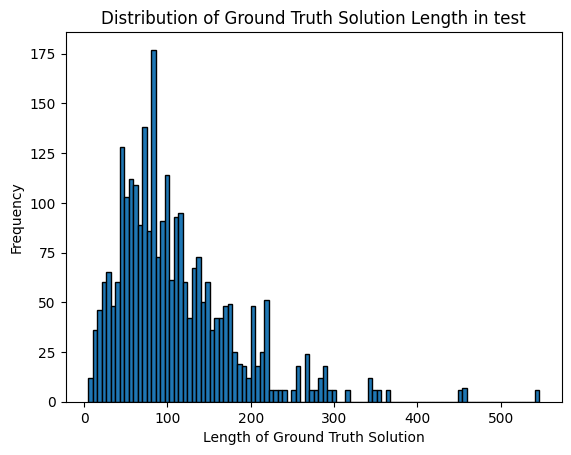

Stage: test
比例大于1024: 0.00%
比例大于2048: 0.00%


In [1]:
#查看每个problem的ground_truth_solution的长度，并绘制分布图
#分布图纵坐标是频率，横坐标是长度
#各个stage的分布图放在一起
#并分别统计长度大于1024与2048在各个stage的占比
import json
from tqdm import tqdm
import matplotlib.pyplot as plt


path = "/zhuangkai/openo1/dataset/prm800k/data/phase2_{stage}.jsonl"
for stage in ["train", "test"]:
    results = []
    count_gt_1024 = 0  # 统计长度大于1024的数量
    count_gt_2048 = 0  # 统计长度大于2048的数量
    total_count = 0     # 统计总数量
    with open(path.format(stage=stage), 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            line = json.loads(line)
            problem = line["question"]['problem']
            gt_solution = line["question"]['ground_truth_solution']
            if gt_solution is not None:
                #将gt_solution用空格来划分，以此统计数量
                length = len(gt_solution.split(" "))+len(problem.split(" "))
                results.append((problem, length))
                total_count += 1  # 增加总数量
                if length > 1024:
                    count_gt_1024 += 1  # 增加长度大于1024的计数
                if length > 2048:
                    count_gt_2048 += 1  # 增加长度大于2048的计数
    plt.hist([length for problem, length in results], bins=100, edgecolor='black')
    plt.xlabel('Length of Ground Truth Solution')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Ground Truth Solution Length in {stage}')
    plt.show()

    # 输出长度大于1024与2048的占比
    print(f'Stage: {stage}')
    print(f'比例大于1024: {count_gt_1024 / total_count * 100:.2f}%')
    print(f'比例大于2048: {count_gt_2048 / total_count * 100:.2f}%')

## 将test划分为test与validation



In [4]:
#将处理过的test划分为test与validation
#按照1：1的比例划分
import json
from tqdm import tqdm
import random
path = "/zhuangkai/openo1/outputs/sft/phase2_test_gt_pre_generated_solution_to_step_list.jsonl"
results = []
with open(path, 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        line = json.loads(line)
        problem = line["problem"]
        results.append((problem, line))

# 随机打乱results
random.shuffle(results)

# 将results分为两部分，按照1：1的比例划分
test_results = results[:len(results)//2]
validation_results = results[len(results)//2:]  

# 将test_results和validation_results写入文件
with open("/zhuangkai/openo1/dataset/prm800k/processsed/phase2_test_gt_pre_generated_solution_to_step_list.jsonl", 'w', encoding='utf-8') as f:
    for problem, line in test_results:
        f.write(json.dumps({"problem": problem, "steps": line["steps"]}) + "\n")

with open("/zhuangkai/openo1/dataset/prm800k/processsed/phase2_validation_gt_pre_generated_solution_to_step_list.jsonl", 'w', encoding='utf-8') as f:
    for problem, line in validation_results:
        f.write(json.dumps({"problem": problem, "steps": line["steps"]}) + "\n")


970it [00:00, 59243.31it/s]
